In [ ]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124


In [ ]:
!pip install --pre dgl -f https://data.dgl.ai/wheels-test/torch-2.4/cu124/repo.html

Looking in links: https://data.dgl.ai/wheels-test/torch-2.4/cu124/repo.html


In [ ]:
# Dependencies and Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
from dgl.nn import SAGEConv
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.version.cuda)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
2.4.0+cu124
12.4


In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and split the dataset
TRAINING_SIZE = 400
TESTING_SIZE = 210
ratings_df = pd.read_csv('/content/drive/My Drive/COMP4222/ml-latest-small/ratings.csv') # Ground truth
train_users = ratings_df['userId'].unique()[:TRAINING_SIZE] # Training users' indices
test_users = ratings_df['userId'].unique()[TRAINING_SIZE:]  # Testing users' indices

train_df = ratings_df[ratings_df['userId'].isin(train_users)] # Training users' dataframe
test_df = ratings_df[ratings_df['userId'].isin(test_users)] # Testing users' dataframe

TOTAL_USER = len(ratings_df["userId"].unique())
TOTAL_MOVIE = len(ratings_df["movieId"].unique())

In [ ]:
# Mask ratings in the test set
def mask_ratings(df, mask_percentage):
    masked_df = df.copy()
    for user in masked_df['userId'].unique():
        user_ratings = masked_df[masked_df['userId'] == user]
        num_to_mask = int(len(user_ratings) * mask_percentage)
        if num_to_mask > 0:
            indices_to_mask = np.random.choice(user_ratings.index, num_to_mask, replace=False)
            masked_df.loc[indices_to_mask, 'rating'] = 0
    return masked_df

In [ ]:
def create_graph_ratings(df, type):
    user_ids = df['userId'].unique()
    movie_ids = df['movieId'].unique()

    user_map = {user_id: i for i, user_id in enumerate(user_ids)}
    movie_map = {movie_id: i + len(user_ids) for i, movie_id in enumerate(movie_ids)}

    src = df['userId'].map(user_map).values
    dst = df['movieId'].map(movie_map).values


    # Creating Graph
    g = dgl.graph((src, dst))

    # Assign features based on type
    g.ndata['feat'] = torch.eye((len(user_ids)+len(movie_ids)), TOTAL_MOVIE)  # One-hot for user nodes

    # Create rating matrix
    if type == "Train":
        rating_matrix = np.zeros((TRAINING_SIZE, TOTAL_MOVIE))  # Ground Truth matrix for training
    elif type == "Test":
        rating_matrix = np.zeros((TESTING_SIZE, TOTAL_MOVIE))  # Ground Truth matrix for training

    rating_matrix = torch.tensor(rating_matrix)  # Convert the rating_matrix(np.array) to Tensor

    # Populate the rating matrix
    for _, row in df.iterrows():
        user_index = user_map[row['userId']]  # Get user index
        movie_index = movie_map[row['movieId']] - len(user_ids) # Get movie index
        # print(f"User Index: {user_index}, Movie Index: {movie_index}, Rating: {row['rating']}")
        rating_matrix[user_index, movie_index] = row['rating']  # Assign the rating

    return g, rating_matrix

In [ ]:
# Mask the testing dataframe
test_df_masked = mask_ratings(test_df, mask_percentage=0.3)
# Get graphs and rating matrices
train_graph, train_rating_matrix = create_graph_ratings(train_df, "Train")
test_graph, test_rating_matrix = create_graph_ratings(test_df_masked, "Test")
_, gt_test_rating_matrix = create_graph_ratings(test_df, "Test") # Ground truth matrix without mask

In [ ]:
print(train_graph)
print(test_graph)
print(train_rating_matrix)
print(test_rating_matrix)

Graph(num_nodes=7794, num_edges=61199,
      ndata_schemes={'feat': Scheme(shape=(9724,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=7892, num_edges=39637,
      ndata_schemes={'feat': Scheme(shape=(9724,), dtype=torch.float32)}
      edata_schemes={})
tensor([[4., 4., 4.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.]], dtype=torch.float64)
tensor([[0.0000, 2.0000, 4.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)


In [ ]:
# Define and train the GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_size1, hidden_size2, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_size1, 'mean')
        self.conv2 = SAGEConv(hidden_size1, hidden_size2, 'mean')
        self.conv3 = SAGEConv(hidden_size2, out_feats, 'mean')


    def forward(self, g, features):
        h = self.conv1(g, features)
        h = torch.relu(h)
        h = self.conv2(g, h)
        h = torch.relu(h)
        h = self.conv3(g, h)
        return h

In [ ]:
# Initialize model, loss function, and optimizer
model = GraphSAGE(in_feats=train_graph.ndata['feat'].shape[1], hidden_size1=512, hidden_size2=256, out_feats=train_rating_matrix.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Parameter loading
# model.load_state_dict(torch.load('/content/drive/My Drive/COMP4222/model_parameters_final2.pth'))

In [ ]:
# Initialize lists to store loss and accuracy
losses = []
accuracies = []

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    logits = model(train_graph, train_graph.ndata['feat'])
    logits = logits[:TRAINING_SIZE]
    logits = torch.clamp(logits, max=5.0, min=0.0)  # Clamping


    # Calculate loss
    loss = loss_fn(logits, train_rating_matrix.float())
    loss.backward()
    optimizer.step()

    # Calculate accuracy based on the difference between predicted and actual ratings
    with torch.no_grad():
        # Define a tolerance level for accuracy
        TOLERANCE = 0.5

        # Get all non-zeros values' indices correponsing to the ground truth matrix
        train_nonzero_indices = torch.nonzero(train_rating_matrix)

        # Values slicing
        train_actual_val = train_rating_matrix[train_nonzero_indices[:, 0], train_nonzero_indices[:, 1]]
        train_pred_val = logits[train_nonzero_indices[:, 0], train_nonzero_indices[:, 1]]

        # Calculate the absolute difference
        diff = torch.abs(train_actual_val - train_pred_val)

        # Count how many predictions are within the tolerance
        correct_predictions = (diff <= TOLERANCE).float()  # Convert to float for mean calculation
        accuracy = correct_predictions.mean().item()  # Calculate mean accuracy


    # Append loss and accuracy to the lists
    losses.append(loss.item())
    accuracies.append(accuracy)

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy:.4f}')

Epoch 0, Loss: 0.2121942937374115, Accuracy: 0.0132
Epoch 5, Loss: 0.1867597997188568, Accuracy: 0.0290
Epoch 10, Loss: 0.179108664393425, Accuracy: 0.0370
Epoch 15, Loss: 0.17114658653736115, Accuracy: 0.0446
Epoch 20, Loss: 0.15701834857463837, Accuracy: 0.0597
Epoch 25, Loss: 0.1388862282037735, Accuracy: 0.0930
Epoch 30, Loss: 0.12140417844057083, Accuracy: 0.1410
Epoch 35, Loss: 0.10551252216100693, Accuracy: 0.1879
Epoch 40, Loss: 0.09151162952184677, Accuracy: 0.2519
Epoch 45, Loss: 0.07939005643129349, Accuracy: 0.3015
Epoch 50, Loss: 0.07070105522871017, Accuracy: 0.3473
Epoch 55, Loss: 0.06353943794965744, Accuracy: 0.4346
Epoch 60, Loss: 0.05867063254117966, Accuracy: 0.4876
Epoch 65, Loss: 0.055904727429151535, Accuracy: 0.5328
Epoch 70, Loss: 0.05453043431043625, Accuracy: 0.5475
Epoch 75, Loss: 0.05258994176983833, Accuracy: 0.6030
Epoch 80, Loss: 0.051754120737314224, Accuracy: 0.6342
Epoch 85, Loss: 0.05119001865386963, Accuracy: 0.6697
Epoch 90, Loss: 0.050935227423906

In [ ]:
# Save the parameters
torch.save(model.state_dict(), '/content/drive/My Drive/COMP4222/Update/model_parameters_final_updated.pth')

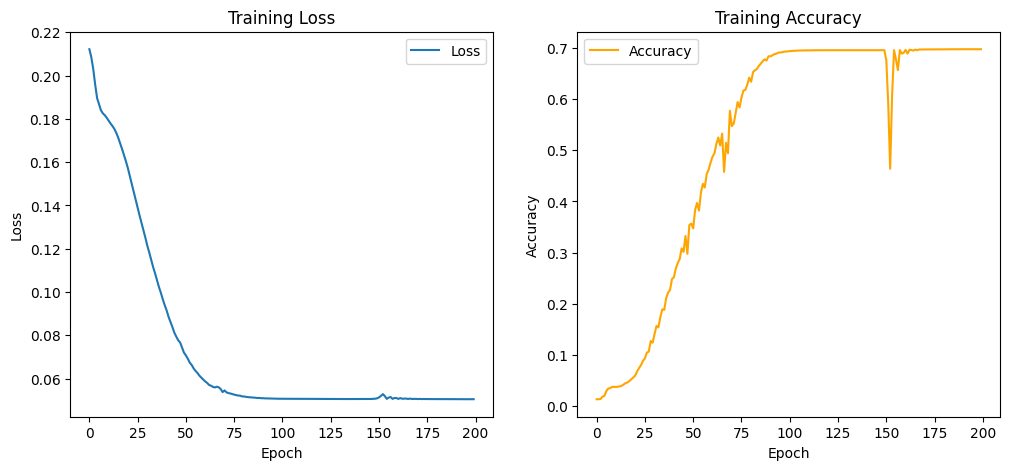

In [ ]:
# After training, you can analyze or visualize the loss and accuracy

# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()

In [ ]:
# Create dataframe for better visualization (Training set)
train_predicted_df = pd.DataFrame(logits.detach().numpy())
train_actual_df = pd.DataFrame(train_rating_matrix.detach().numpy())

In [ ]:
print("Dataframe for the predicted ratings of the training dataset: ")
train_predicted_df

Dataframe for the predicted ratings of the training dataset: 


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,3.976604,3.941752,4.000809,5.000000,5.000000,2.95098,0.0,4.013961,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,1.970031,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.987694,0.000000,0.000000,0.000000,4.005059,0.00000,0.0,4.014525,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5.000000,0.000000,0.000000,0.000000,4.017390,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,3.017801,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Dataframe for the actual ratings of the training dataset: ")
train_actual_df

Dataframe for the actual ratings of the training dataset: 


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.0,4.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Predicted ratings for training set:", logits)
print("Actual ratings: ", train_rating_matrix)

Predicted ratings for training set: tensor([[3.9766, 3.9418, 4.0008,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 5.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ClampBackward1>)
Actual ratings:  tensor([[4., 4., 4.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 5.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [ ]:
# Evaluate the model using the test graph
model.eval()
with torch.no_grad():
    test_logits = model(test_graph, test_graph.ndata['feat'])
    test_logits = test_logits[:TESTING_SIZE]
    test_logits = torch.clamp(test_logits, max=5.0, min=0.0)
    test_loss = loss_fn(test_logits, test_rating_matrix)

In [ ]:
# Create dataframe for better visualization (Testing set)
test_predicted_df = pd.DataFrame(test_logits.detach().numpy())
test_actual_df = pd.DataFrame(test_rating_matrix.detach().numpy())

In [ ]:
print("Dataframe for the predicted ratings of the testing dataset: ")
test_predicted_df

Dataframe for the predicted ratings of the testing dataset: 


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,3.980878,4.041082,4.017765,5.000000,5.000000,3.006147,0.0,3.991730,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,1.993339,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.987873,0.000000,0.000000,0.000000,3.976639,0.000000,0.0,4.006805,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.989890,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Dataframe for the actual ratings of the testing dataset: ")
test_actual_df

Dataframe for the actual ratings of the testing dataset: 


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.0,2.0,4.5,0.0,3.5,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2.5,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207,0.0,0.5,0.0,3.0,0.0,3.5,3.0,2.5,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Predicted ratings for testing set: ", test_logits)
print("\n")
print("Actual ratings: ", test_rating_matrix)

Predicted ratings for testing set:  tensor([[3.9809, 4.0411, 4.0178,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


Actual ratings:  tensor([[0.0000, 2.0000, 4.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)


In [ ]:
# Define a tolerance level for accuracy
TOLERANCE = 1

# Calculate accuracy for the test set
# Get all non-zero indices corresponding to the ground truth matrix
nonzero_indices = torch.nonzero(test_rating_matrix)

# Extract actual and predicted values for these indices
actual_values = test_rating_matrix[nonzero_indices[:, 0], nonzero_indices[:, 1]]
predicted_values = test_logits[nonzero_indices[:, 0], nonzero_indices[:, 1]]

# Calculate the absolute difference
diff = torch.abs(actual_values - predicted_values)

# Count how many predictions are within the tolerance
correct_predictions = (diff <= TOLERANCE).float()  # This will be 1 for correct predictions, 0 for incorrect

# Calculate mean accuracy
accuracy = correct_predictions.mean().item()  # Convert to a Python float for easy printing

# Print the accuracy
print(f'Loss: {test_loss.item()}, Accuracy: {accuracy:.4f}')

Loss: 0.32840775636874175, Accuracy: 0.0638


In [ ]:
# Assuming gt_test_rating_matrix is the ground truth matrix (unmasked)
# and test_rating_matrix is the masked matrix (with zeros)

# Identify masked positions
masked_pos = (gt_test_rating_matrix > 0) != (test_rating_matrix > 0)  # True where values were masked

# Check updated values at masked positions
for i in range(1):
    if masked_pos[i].any():  # If there are any masked positions for this user
        updated_values = test_logits[i][masked_pos[i]]  # Get the predicted values for masked positions
        actual_values = gt_test_rating_matrix[i][masked_pos[i]]
        print(f"Ground truth ratings for user {i}: {actual_values}")
        print("\n")
        print(f"Updated predictions for user {i}: {updated_values}")

print("\n")

# Recommendations (By sorting the updated values)
for i in range(1):
    if masked_pos[i].any():  # If there are any masked positions for this user
        recommendations = test_logits[i][masked_pos[i]].topk(k=5)  # Get top 5 recommendations
        print(f"Top 5 recommendations for user {i}: {recommendations}")

Ground truth ratings for user 0: tensor([4.5000, 3.5000, 3.5000, 2.0000, 4.0000, 4.0000, 3.5000, 3.5000, 3.5000,
        1.5000, 4.0000, 3.5000, 3.5000, 4.5000, 3.0000, 3.0000, 3.5000, 4.0000,
        3.0000, 3.5000, 3.0000], dtype=torch.float64)


Updated predictions for user 0: tensor([3.5137, 4.6371, 0.0000, 5.0000, 5.0000, 4.2231, 3.4339, 0.0000, 5.0000,
        5.0000, 5.0000, 0.0000, 4.7780, 0.0000, 0.0000, 4.2507, 5.0000, 4.1140,
        5.0000, 5.0000, 0.0000])


Top 5 recommendations for user 0: torch.return_types.topk(
values=tensor([5., 5., 5., 5., 5.]),
indices=tensor([16,  9,  8, 10,  3]))
